In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import normflows as nf
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from fab import FABModel, HamiltonianMonteCarlo, Metropolis
from fab.utils.logging import ListLogger
from fab.utils.plotting import plot_history, plot_contours, plot_marginal_pair
from fab.target_distributions.gmm import GMM
from fab.utils.prioritised_replay_buffer import SimpleBuffer
from torch.autograd import grad
from fab.utils.plotting import plot_contours, plot_marginal_pair
from experiments.make_flow import make_wrapped_normflow_realnvp
import models.ddpm
import models.mlp
import pdb
from tqdm import tqdm
from models.ddpm import GaussianDiffusion, TMLP
from models.mlp import MyMLP, SpectralNormMLP

import torch
import torchsde

from functorch import vmap

from torchdiffeq import odeint


from torch.func import jacrev

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [62]:
c = 4

In [63]:
x1 = torch.rand(1000, 2).to(device) * c

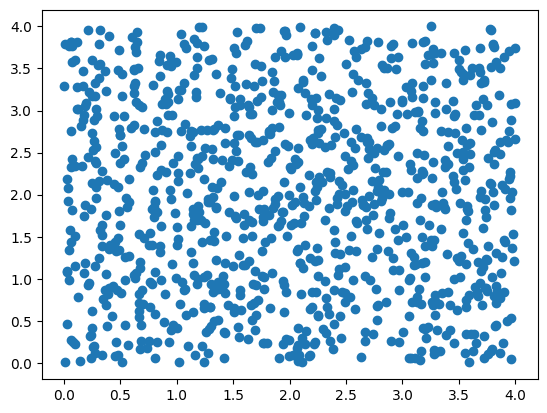

In [64]:
plt.scatter(x1[:, 0].cpu(), x1[:, 1].cpu())

In [65]:
def drift(x, t):
    with torch.enable_grad():
        v = 2 *  x
    return v

In [66]:
def div_fn(u):
    """Accepts a function u:R^D -> R^D."""
    J = jacrev(u)
    return lambda x: torch.trace(J(x))


def output_and_div(vecfield, x):
    dx = torch.vmap(vecfield, randomness="different")(x)
    return dx, torch.vmap(div_fn(vecfield), randomness="different")(x)

In [86]:
def odefunc(t, x_in):
    x = x_in[..., :-1]
    t = t.to(device)
    vecfield = lambda x: drift(x, t)
    dx, div = output_and_div(vecfield, x)
    div = div.reshape(-1, 1)
    return torch.cat([dx, div], dim=-1)


with torch.no_grad():
    state1 = torch.cat([x1, torch.zeros_like(x1[..., :1])], dim=-1)
    state1.requires_grad = True
    state0 = odeint(odefunc, state1, t=torch.linspace(0, 1, 100).to(device), method="euler")[-1]
    x0, logdetjac = state0[..., :-1], state0[..., -1]
    logp1 = -np.log(c**2) - logdetjac
    # logp1 = logp0 - logdetjac

In [87]:
logp1.mean()

tensor(-6.7726, device='cuda:0')

In [88]:
-np.log(c**2) - 2**2

-6.772588722239782

In [40]:
2 * np.exp(2)

14.7781121978613

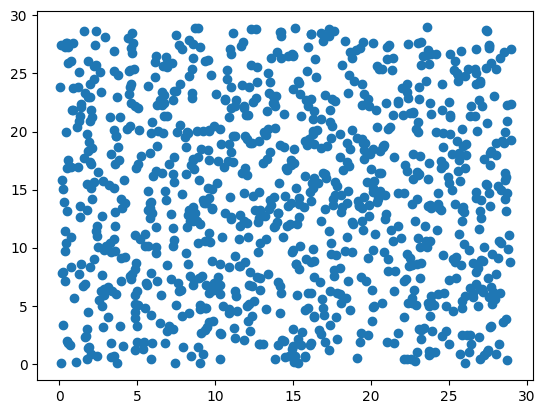

In [73]:
a = (x1 * torch.exp(2 * torch.tensor(0.99))).cpu().numpy()
plt.scatter(a[:,0], a[:, 1])

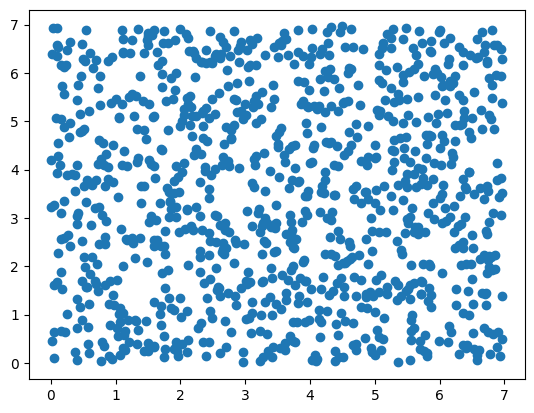

In [11]:
plt.scatter(x0[:, 0].cpu(), x0[:, 1].cpu())